In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json

In [0]:
#To ensure reproducibility
random.seed(11)
np.random.seed(11)

In [3]:
# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    
train_images = train_set[0]
#make images binary
train_images = (train_images > 0.5)
train_labels = train_set[1]

test_images = test_set[0]
#make images binary
test_images = (test_images > 0.5)
test_labels = test_set[1]

# Check that we have the expected shape of arrays, should be (50000, 784), (50000,), (10000, 784), (10000,)
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)


(28, 28)
5


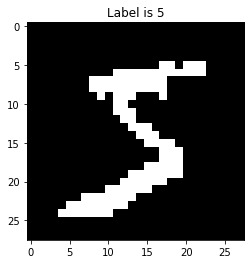

In [4]:
#Plot the first training image and label
for i in range(1):
    train_sample1 = train_images[i,:]
    train_sample1 = train_sample1.reshape((28, 28))
    label = train_labels[i]
    print(train_sample1.shape)
    print(label)

    plt.title('Label is {label}'.format(label=label))
    plt.imshow(train_sample1, cmap='gray')
    plt.show()

In [0]:
class boltzmann_machine(object):
    """
    Define a class for a boltzmann machine here.
    You must also define the functions below, but you can add additional arguments, etc.
    Also, note that you are welcome to write your own helper functions. 
    Reminder: you should use numpy functions for vector and matrix operations. No autograd!
    """
    
    #The initialization function for the boltzmann machine
    def __init__(self,hidden_units,learning_rate,schedule,tempurature):
        #ensures results are reproducible
        random.seed(596)
        np.random.seed(596)

        #number of hidden units
        self.h = hidden_units
        #number of visible units
        self.v = 28*28
        #number of units
        self.n = self.h + self.v
        #learning rate
        self.learn_rate = learning_rate
        #annealing schedule (Number of iterations at each schedule index)
        self.schedule = schedule
        #annealing schedule (Tempurature at each schedule index)
        self.tempurature = tempurature
        #current activation state for all units
        #this is randomly reset every time we run gibbs sampling
        self.a = np.random.randint(2, size=self.n)
        #Threshold term for all units
        #These value are learned during training
        self.threshold = np.random.normal(0,1,self.n)
        #Weights for all units connectivity 
        #These values are learned during training
        self.W = np.random.normal(0,1,(self.n,self.n))
        #Weight matrix needs to be symmetric!
        self.W = (self.W + self.W.T)/2
        #W_ii = 0 for all i
        #Therefore all diagonal elements in weight matrix set to 0 
        np.fill_diagonal(self.W, 0)
        #W_(v_i,v_j) = 0 for all v_i,v_j (Visible units do not connect to each other)
        #Therefore bottom right block of weight matrix set to zero (see Question 1.1 for visual)
        self.W[self.h:,self.h:] = 0
        #The average activation of every unit during the dream phase
        #This term is used in calculating the loss
        self.activation_minus = np.zeros(self.n) 
    
    #The function for Gibbs sampling
    def gibbs(self,num_units):
        #Activation data
        #This will store the average activation for each unit across all iterations after burn-in
        act_data = np.zeros(self.n)
        #Co-activation data
        #This will store the average co-activation for each pair of units across all iterations after burn in
        co_data = np.zeros([self.n,self.n])
        #Temporary matrix, helps speed up the computation of co_data
        #Stores the co-activation for each pair of units in the current iteration
        temp_data = np.zeros([self.n,self.n])

        #Iterate through schedule
        for i in range(len(self.schedule)):
            #Iterate for length specified by schedule entry and number of units allowed to change 
            #num_units = self.h => we are in awake phase
            #num_units = self.n => we are in dream phase
            for j in range(int(self.schedule[i]*num_units)):
                #select neuron at random (from eligble neurons)
                neuron = np.random.randint(num_units)
                #Update neuron's activation with current annealing tempurature via stochastic activation 
                self.activation_function(neuron,self.tempurature[i])

                #If we are done our burn-in
                #Equivilantly we are on the last entry in the schedule
                #This is when we want to collect co-activation and activation data!
                if i == (len(self.tempurature)-1):
                    #First time collecting co-activation data we need to explicitly compute the outer product
                    if j == 0:
                        temp_data = np.outer(self.a,self.a)
                    #After the first time collecting co-activation data we DO NOT need to compute the full outer product
                    #Becuase only one activation changed, only one row and column in the co-activation matrix has changed
                    #Therefore we can simply update the row and column of the selected neuron and save a bit of time!
                    else:
                        #If neuron has been set to 1
                        #row and column should be the activation vector
                        if self.a[neuron] == 1:
                            temp_data[neuron,:] = self.a
                            temp_data[:,neuron] = self.a
                        #If neuron has been set to 0
                        #row and column should be the zero vector
                        else:
                            temp_data[neuron,:] = 0
                            temp_data[:,neuron] = 0
                    
                    #Update co-activation data
                    co_data = np.add(co_data,temp_data)
                    #Update activation data
                    act_data = np.add(act_data,self.a)
                
        #Divide co-activation and activation data by the number of times we collected data
        #This scales every entry to be in [0,1]
        co_data = np.divide(co_data,int(self.schedule[-1]*num_units))
        act_data = np.divide(act_data,int(self.schedule[-1]*num_units))
        #return data from gibbs sampling
        return co_data, act_data
    
    #The function for training the boltzmann machine
    def train(self,train_images,epoch_i):
        #Keep track of average image loss in this epoch
        L = 0
        #Run Dream Phase for Epoch i (does not require training images)
        print('Running dream phase')
        co_activation_minus, self.activation_minus = self.dream()
        #Run Wake Phase (requires training images)
        print('Running wake phase')
        #Iterate through each image once on average and update weights
        for i in range(len(train_images)):
            #Randomly select an image
            index = np.random.randint(len(train_images))
            image = train_images[index]
            #collect data on that image 
            co_activation_plus, activation_plus = self.awake(image)
            #Compute update for weights and thresholds
            self.weight_update(co_activation_plus, activation_plus,co_activation_minus, self.activation_minus)
            #calculate and update average image loss (requires training image and activation data from dream phase)
            L += (self.loss_function(image,self.activation_minus))/len(train_images)
        #print average training loss per image during epoch
        print('Average training loss per image at Epoch',epoch_i,':', L) 

    # The function for testing the boltzmann machine
    def test(self,test_images,epoch):
        #Keep track of average image loss in this epoch
        L = 0
        #loop through all test images
        for i in range(len(test_images)):
            image = test_images[i]
            #calculate the loss on the test image using activation data from dream phase
            #update average image loss
            L += self.loss_function(image,self.activation_minus)/len(test_images)
        #print average image loss on test images during epoch
        print('Average testing loss per image at Epoch',epoch,':', L)
        print('\n')
    
    #The function for testing the boltzmann machine
    #def test(self):
    #renamed this function!
    def test_generate_images(self,number_images_generate):
        #This will store the images
        images = np.zeros([number_images_generate,self.v])
        #Iterate for number of images to generate
        for i in range(number_images_generate):
            #randomly initialize activation vector
            self.a[0:self.n] = np.random.randint(2, size=self.n)
            #run gibbs sampling
            #allow all n units to change activation values
            self.gibbs(self.n)
            #After gibbs sampling the image is just the activation on all the visible units 
            images[i,:] = self.a[self.h:]
        #return generated images
        return images

    ####Helper functions below#######

    #Stochastic activation function 
    #determines what activation to assign a specified neuron
    def activation_function(self,i,temp): 
        #Compute weights on connections coming from other active units (via dot product of matrix row and activation vector)
        #add neuron i's threshold term
        z = np.dot(self.W[i,:], self.a[:]) + self.threshold[i]
        
        #Calculate probability of activation for unit i according to equation in slides
        prob = 1.0/(1 + np.exp(-z/temp))

        #Using probability of activation, stochastically determine whether neuron should be activated or not
        #and update activation vector accordingly
        if prob > np.random.random_sample():
            self.a[i] = 1
        else:
            self.a[i] = 0

    #Awake phase
    def awake(self,image):
        #Clamp pixel values to activations for visible units
        #These will NOT change during gibbs sampling
        self.a[self.h:] = image
        #set activations randomly for hidden units
        #These CAN change during gibbs sampling
        self.a[0:self.h] = np.random.randint(2, size=self.h)
        #run gibbs sampling
        #allow only hidden units to change activation values
        return self.gibbs(self.h)


    #Dream phase
    def dream(self):
        #randomly initialize activation vector
        #These CAN change in gibbs sampling
        self.a[0:self.n] = np.random.randint(2, size=self.n)
        #run gibbs sampling
        #allow all units to change activation values
        #return data from dream phase
        return self.gibbs(self.n)

    #weight matrix and threshold vector updates
    def weight_update(self,co_activation_plus, activation_plus, co_activation_minus, activation_minus):
        #calculate weight update using co-activation data from wake and dream phases and learning rate
        delta_W = np.multiply((self.learn_rate/self.tempurature[-1]),(np.subtract(co_activation_plus,co_activation_minus)))
        #update weight matrix
        self.W = np.add(self.W,delta_W)
        
        #W_ii = 0 for all i
        #Therefore all diagonal elements in weight matrix set to 0
        np.fill_diagonal(self.W, 0)
        #W_(v_i,v_j) = 0 for all v_i,v_j (Visible units do not connect to each other)
        #Therefore bottom right block of weight matrix set to zero (see Question 1.1 for visual)
        self.W[self.h:,self.h:] = 0

        #calculate threshold update using activation data from wake and dream phases and learning rate
        delta_threshold = np.multiply((self.learn_rate/self.tempurature[-1]),(np.subtract(activation_plus,activation_minus)))
        #update threshold vector
        self.threshold = np.add(self.threshold,delta_threshold)

    #compute loss on provided images
    def loss_function(self,image,activations):
        #Because the activation function does not change during loss calculation
        #we can pre-compute activation probability for each unit ahead of time
        #this makes computing the loss much faster
        prob_vector = self.math(activations)
        #iterate through each image
            
        #variable to track loss across all pixels in image
        image_loss = 0
        #iterate through pixels in image
        for j in range(len(image)):
            #Compute the probability of each pixel value given the activation probabilities of the hidden units
            if image[j] == 1:
                prob = prob_vector[self.h+j]
            else:
                prob = 1-prob_vector[self.h+j]

            #avoid any log(0) issues!
            if prob < 1e-15:
               prob = 1e-15

            #add the log probability to the image loss
            image_loss += np.log(prob)
       
        #return negative image loss 
        return -image_loss

    #Helper function
    #Speeds up loss calculation
    #compute and return vector of activation probabilities for all units
    def math(self,activation):
        #compute input for all units
        z = np.dot(self.W, activation) + self.threshold
        #calculate probability of activation for all units
        prob = 1.0/(1 + np.exp(-z/self.tempurature[-1]))
        #return vector of probabilities
        return prob
    

In [6]:
# Create a Boltzmann machine and train it

#Boltzmann machine parameters
hidden_units = 400
learning_rate = 0.001
#Annealing schedule and corresponding tempuratures
#These need to be the same length
#NOTE: we only collect co-activation statistics for 1 iteration at tempurature 1
#Please refer to answer for Q2.3 for how we have defined 1 iteration
schedule = np.array([2,4,8,49,1])
temp = np.array([10,5,2,1,1])

#Running the boltzmann machine is a little slow, so just use a subset of images
subset_train_images = train_images[0:50]
subset_test_images = test_images[0:500]

#Number of epochs we want to train Boltzmann machine for
training_epochs = 7
#number of images we want to generate after training is done
number_images_generate = 20

#Create boltzmann machine with parameters above
bm = boltzmann_machine(hidden_units,learning_rate,schedule,temp,)

for i in range(training_epochs):
    #train for 1 epoch
    print('Starting Epoch',i)
    bm.train(subset_train_images,i)
    #test at the end of epoch
    bm.test(subset_test_images,i)

#generate sample images
print('Generating',number_images_generate,'Images')
images = bm.test_generate_images(number_images_generate)
print('Images Generated!')

Starting Epoch 0
Running dream phase
Running wake phase
Average training loss per image at Epoch 0 : 3149.8032817051153
Average testing loss per image at Epoch 0 : 1693.1764484529638


Starting Epoch 1
Running dream phase
Running wake phase
Average training loss per image at Epoch 1 : 1806.945039523175
Average testing loss per image at Epoch 1 : 1093.781715515355


Starting Epoch 2
Running dream phase
Running wake phase
Average training loss per image at Epoch 2 : 1172.6230946127725
Average testing loss per image at Epoch 2 : 770.0250489300967


Starting Epoch 3
Running dream phase
Running wake phase
Average training loss per image at Epoch 3 : 719.2780264712136
Average testing loss per image at Epoch 3 : 612.9823282344964


Starting Epoch 4
Running dream phase
Running wake phase
Average training loss per image at Epoch 4 : 609.3961922474188
Average testing loss per image at Epoch 4 : 562.6010260078492


Starting Epoch 5
Running dream phase
Running wake phase
Average training loss per 

(28, 28)


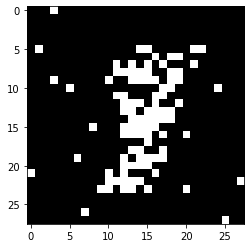

(28, 28)


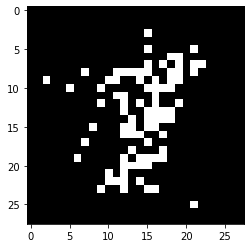

(28, 28)


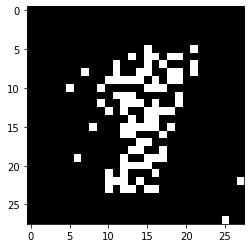

(28, 28)


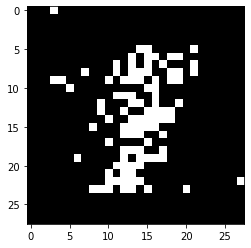

(28, 28)


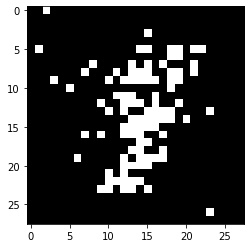

(28, 28)


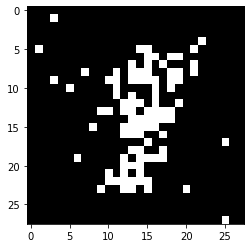

(28, 28)


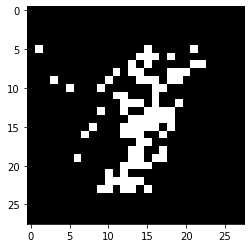

(28, 28)


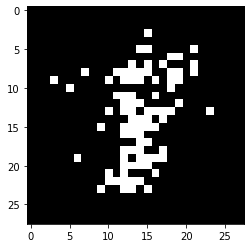

(28, 28)


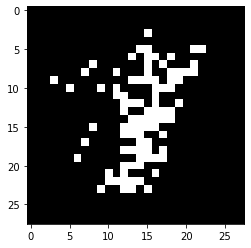

(28, 28)


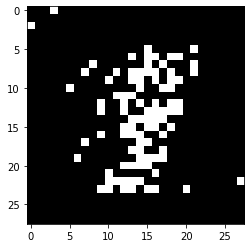

(28, 28)


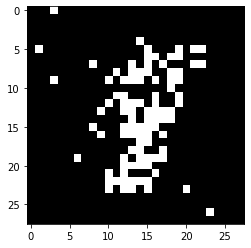

(28, 28)


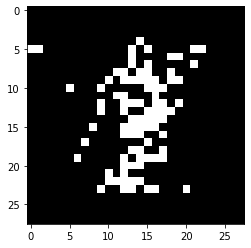

(28, 28)


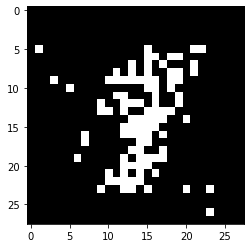

(28, 28)


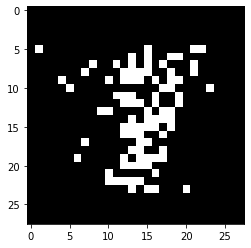

(28, 28)


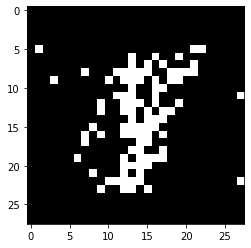

(28, 28)


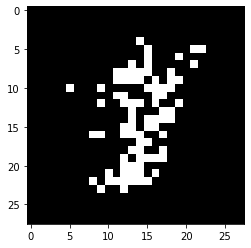

(28, 28)


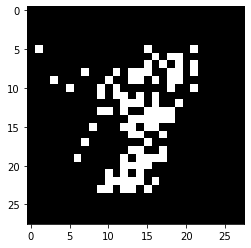

(28, 28)


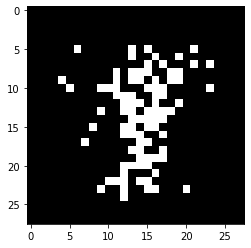

(28, 28)


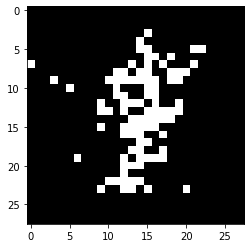

(28, 28)


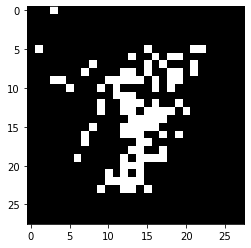

In [7]:
#Display generated images from Boltzmann machine
for i in range(len(images)):
    train_sample1 = images[i,:]
    train_sample1 = train_sample1.reshape((28, 28))
    print(train_sample1.shape)

    plt.imshow(train_sample1, cmap='gray')
    plt.show()